# Example: parallel experiments in eight schools

In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

from scipy.stats import norm, chi2

import matplotlib.pyplot as plt

from scipy.special import logsumexp

A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. We consider the sampling variances known, for all practical purposes, because the sample sizes in all the eight experiments were relatively large.

In [2]:
DatGroup = pd.DataFrame(
    {
        'Group': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        , 'MeanGroup': [28, 8, -3, 7, -1, 1, 18, 12]
        , 'SigmaJ': [15, 10, 16, 11, 9, 11, 10, 18]
    }
)

DatGroup['Sigma2J'] = DatGroup['SigmaJ']**2

J = len(DatGroup)

ALPHA_LEVEL = 0.05

## Separate estimates

We can consider each experiment separately with the following model: $$Y_j|\theta_j\sim\textsf{Normal}(\theta_j,\sigma_j^2)$$ and $$p(\theta_j)\propto 1,$$ so the posterior would be $$\theta_j|Y_j\sim\textsf{Normal}(Y_j,\sigma_j^2).$$

In [3]:
low_posterior_interval = norm.ppf(ALPHA_LEVEL/2, loc=DatGroup['MeanGroup'], scale=DatGroup['SigmaJ'])
upp_posterior_interval = norm.ppf(1-ALPHA_LEVEL/2, loc=DatGroup['MeanGroup'], scale=DatGroup['SigmaJ'])

Text(0, 0.5, '95% hightest posterior density for each $\\theta$')

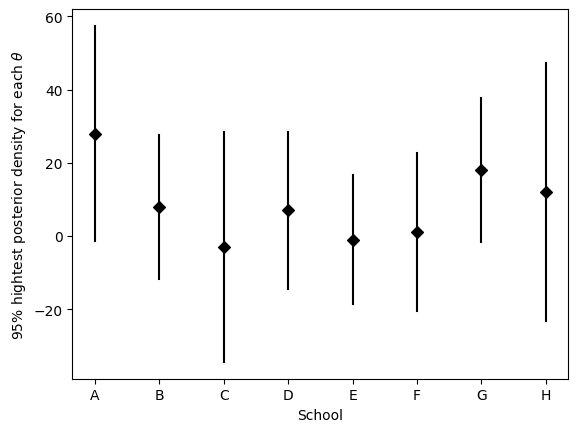

In [4]:
for j in range(J):
    plt.plot(
        [j, j],
        [low_posterior_interval[j], upp_posterior_interval[j]],
        color='k')
    
plt.scatter(range(J), DatGroup['MeanGroup'], marker='D', color='k', label='Pooled estimate')

plt.xticks(ticks=range(J), labels=DatGroup['Group'])
plt.xlabel("School")
plt.ylabel(r"95% hightest posterior density for each $\theta$")

Treatening each experiment separately yields 95% posterior intervals which overlap substantially.

## A pooled estimate

The general overlap in the posterior intervals based on independent analyses suggests that all experiments might be estimating the same quantity. Under the hypothesis that all experiments have the same effect and produce independent estimates of this common effect, we could treat the data as eight normally distributed observations: $$Y_j\sim\textsf{Normal}(\theta,\sigma_j^2).$$

If we model $p(\theta)\propto 1$ then $\theta|\bm{Y}\sim\textsf{Normal}(\bar{Y}_{\cdot\cdot}, \varphi^2)$, where $$\bar{Y}_{\cdot\cdot}=\frac{\sum_{j=1}^J \frac{1}{\sigma_j^2}Y_j}{\sum_{j=1}^J \frac{1}{\sigma_j^2}}$$ and $$\varphi^2=\frac{1}{\sum_{j=1}^J\frac{1}{\sigma_j^2}}$$

In [5]:
HatMuEmpirical = np.average(DatGroup['MeanGroup'], weights=1 / DatGroup['Sigma2J'])
VarPooledEstimate = 1/sum(1/DatGroup['Sigma2J'])

To know the goodness-of-fit of the model we can consider the posterior predictive, which would be given by $$Y_j|\mathbf{Y}\sim\textsf{Normal}(\bar{Y}_{\cdot\cdot}, \sigma_j^2+\varphi^2)$$

In [6]:
DatGroup['LowPredictionPooled'] = norm.ppf(
    q = 0.025
    , loc = HatMuEmpirical
    , scale = np.sqrt(DatGroup['Sigma2J'] + VarPooledEstimate)
)

DatGroup['UppPredictionPooled'] = norm.ppf(
    q = 0.975
    , loc = HatMuEmpirical
    , scale = np.sqrt(DatGroup['Sigma2J'] + VarPooledEstimate)
)

Text(0, 0.5, '95% prediction interval for each $Y_j$')

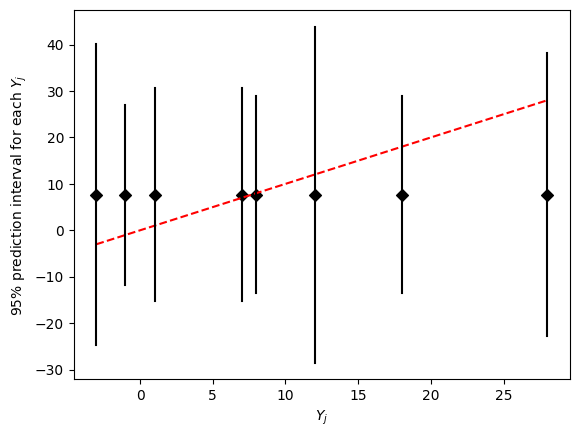

In [7]:
plt.plot(
    [DatGroup['MeanGroup'].min(), DatGroup['MeanGroup'].max()],
    [DatGroup['MeanGroup'].min(), DatGroup['MeanGroup'].max()],
    color='r', linestyle='--'
)

plt.scatter(DatGroup['MeanGroup'], [HatMuEmpirical]*J, marker='D', color='k')

for j in range(J):
    plt.plot(
        [DatGroup['MeanGroup'][j], DatGroup['MeanGroup'][j]],
        [DatGroup['LowPredictionPooled'][j], DatGroup['UppPredictionPooled'][j]]
        , color='k'
    )

plt.xlabel(r"$Y_j$")
plt.ylabel(r"95% prediction interval for each $Y_j$")

## Hierarchical model

In [8]:
def VMuFunc(tau):
    return 1 / sum(1/(DatGroup['Sigma2J'] + tau**2))

VMuFunc = np.vectorize(VMuFunc)

def HatMuFunc(tau):
    return sum(DatGroup['MeanGroup'] / (DatGroup['Sigma2J'] + tau**2)) * VMuFunc(tau)

HatMuFunc = np.vectorize(HatMuFunc)

def PosteriorTau(tau):

    a = np.log(VMuFunc(tau))
    b = np.sum(np.log(DatGroup['Sigma2J'] + tau**2))
    c = np.sum((DatGroup['MeanGroup'] - HatMuFunc(tau))**2 / (DatGroup['Sigma2J'] + tau**2))

    return np.exp(0.5 * (a - b - c))

PosteriorTau = np.vectorize(PosteriorTau)

def VThetaFuncAux(j, tau):
    DatAux = DatGroup[DatGroup['Group']== j]
    return 1 / (1 / DatAux['Sigma2J'] + 1/tau**2)

VThetaFuncAux = np.vectorize(VThetaFuncAux)

def HatThetaFunc(j, tau):
    DatAux = DatGroup[DatGroup['Group']== j]
    return (DatAux['MeanGroup'] / DatAux['Sigma2J'] + HatMuFunc(tau) / tau**2) * VThetaFuncAux(j, tau)

HatThetaFunc = np.vectorize(HatThetaFunc)

def StdThetaFunc(j, tau):
    return np.sqrt(VThetaFuncAux(j, tau) + 1/tau**4 * VMuFunc(tau) * VThetaFuncAux(j, tau)**2)

StdThetaFunc = np.vectorize(StdThetaFunc)

We get the MAP for $\tau$ and calculate an approx. confidence interval.

In [9]:
TauVect = np.linspace(0.01, 30, num=100)
PosteriorTauVect = PosteriorTau(TauVect)
HatTauFull = TauVect[np.argmax(PosteriorTauVect)]

NormalizedPosteriorTau =  PosteriorTauVect / PosteriorTau(HatTauFull)
CutLevel = np.exp(-0.5 * chi2.ppf(1-ALPHA_LEVEL, df=1))

LowConfidenceTau = TauVect[NormalizedPosteriorTau > CutLevel][0]
UppConfidenceTau = TauVect[NormalizedPosteriorTau > CutLevel][-1]

Normalized posterior density of $\tau$

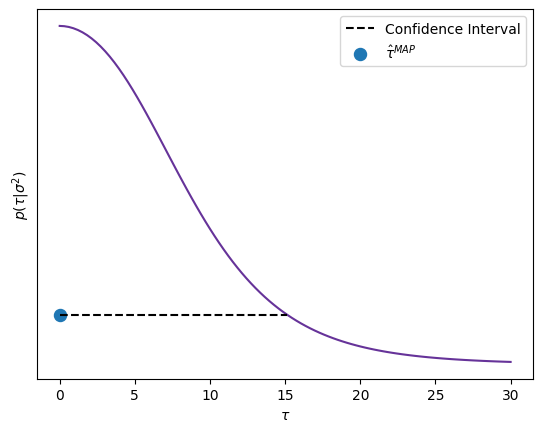

In [10]:
plt.plot(TauVect, NormalizedPosteriorTau, color='rebeccapurple')
plt.hlines(CutLevel, LowConfidenceTau, UppConfidenceTau, ls='--', color='k', label='Confidence Interval')
plt.scatter(HatTauFull, CutLevel, marker='o', s=75, label=r'$\hat\tau^{MAP}$')

plt.xlabel(r'$\tau$')
plt.ylabel(r'$p(\tau|\sigma^2)$')

plt.yticks([], [])
plt.legend()

We get a full Bayesian estimate for $\mu$ using $\hat{\mu}$ evaluated in the MAP of $\tau$. And compute a confidence interval.

In [11]:
HatMuFull = HatMuFunc(HatTauFull).reshape(1,)[0]
LowConfidenceMu = HatMuFull - np.sqrt(VMuFunc(HatTauFull)) * norm.ppf(1 - ALPHA_LEVEL / 2)
UppConfidenceMu = HatMuFull + np.sqrt(VMuFunc(HatTauFull)) * norm.ppf(1 - ALPHA_LEVEL / 2)

In [12]:
MuVect = np.linspace(
    LowConfidenceMu - np.sqrt(VMuFunc(HatTauFull))
    , UppConfidenceMu + np.sqrt(VMuFunc(HatTauFull))
    )

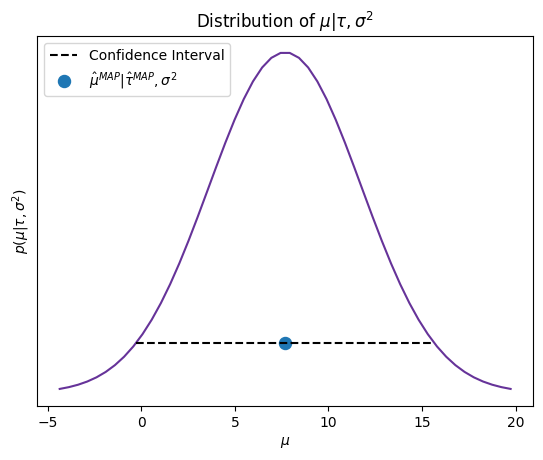

In [13]:
CutLevel = norm.pdf(LowConfidenceMu, loc=HatMuFull, scale=np.sqrt(VMuFunc(HatTauFull)))

plt.plot(MuVect, norm.pdf(MuVect, loc=HatMuFull, scale=np.sqrt(VMuFunc(HatTauFull))), color='rebeccapurple')
plt.hlines(CutLevel, LowConfidenceMu, UppConfidenceMu, ls='--', color='k', label='Confidence Interval')
plt.scatter(HatMuFull, CutLevel, marker='o', s=75, label=r'$\hat\mu^{MAP}|\hat\tau^{MAP},\sigma^2$')

plt.title(r"Distribution of $\mu|\tau,\sigma^2$")

plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|\tau,\sigma^2)$')

plt.yticks([], [])

plt.legend(loc='upper left')

This plot is for the conditional posterior means of treatment effects, $E(\theta_j|\sigma,\tau,\mathbf{Y})$.

/usr/lib/python3.11/site-packages/numpy/lib/function_base.py:2415: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  res = asanyarray(outputs, dtype=otypes[0])


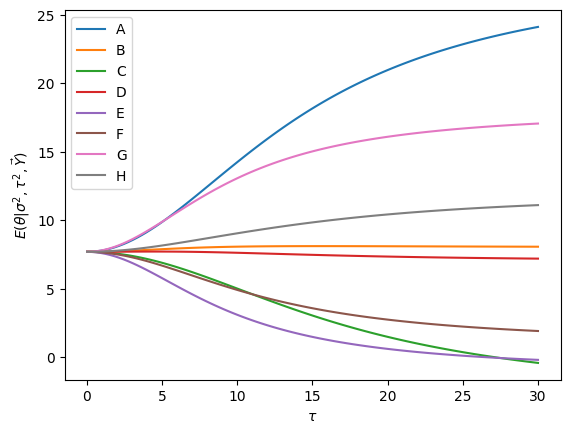

In [14]:
for j in DatGroup['Group']:
    plt.plot(TauVect, HatThetaFunc(j, TauVect), label=j)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\theta|\sigma^2,\tau^2,\vec{Y})$')

plt.legend()

This plot is for the conditional posterior means of treatment effects, $\textsf{Std}(\theta_j|\sigma,\tau,\mathbf{Y})$.

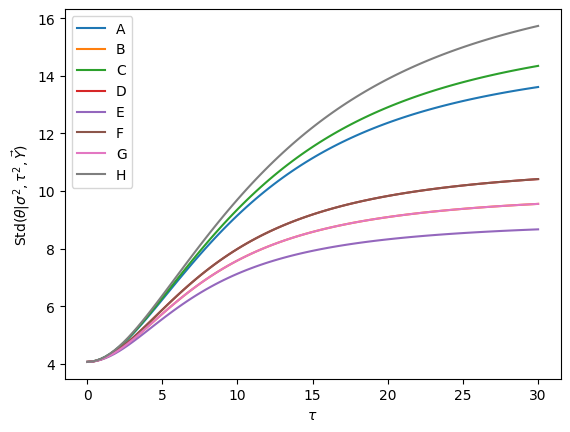

In [15]:
for j in DatGroup['Group']:
    plt.plot(TauVect, StdThetaFunc(j, TauVect), label=j)

plt.xlabel(r'$\tau$')
plt.ylabel(r'Std$(\theta|\sigma^2,\tau^2,\vec{Y})$')

plt.legend()

### Using Pymc

In [16]:
with pm.Model() as model_schools:
    mu    = pm.Flat('mu')
    tau   = pm.HalfFlat('tau')
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs   = pm.Normal('obs', mu=theta, sigma=DatGroup['SigmaJ'], observed=DatGroup['MeanGroup'])

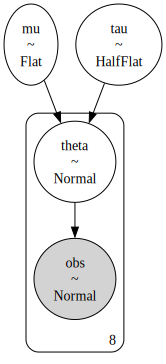

In [17]:
pm.model_to_graphviz(model_schools)

In [18]:
with model_schools:
    trace_schools = pm.sample()
    trace_schools.extend(pm.sample_posterior_predictive(trace_schools))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [obs]


In [19]:
PosteriorPredictiveSummary = az.summary(trace_schools, group='posterior_predictive', hdi_prob=0.95, kind='stats')
PosteriorPredictiveSummary = PosteriorPredictiveSummary.reset_index(drop=True)

In [20]:
DatGroup = pd.concat([DatGroup, PosteriorPredictiveSummary], axis=1)

Text(0, 0.5, '95% prediction interval for each $Y_j$')

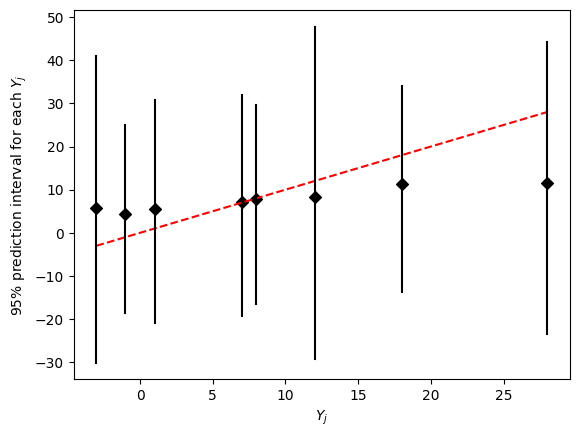

In [27]:
plt.plot(
    [DatGroup['MeanGroup'].min(), DatGroup['MeanGroup'].max()],
    [DatGroup['MeanGroup'].min(), DatGroup['MeanGroup'].max()],
    color='r', linestyle='--'
)

plt.scatter(DatGroup['MeanGroup'], DatGroup['mean'], marker='D', color='k')

for j in range(J):
    plt.plot(
        [DatGroup['MeanGroup'][j], DatGroup['MeanGroup'][j]],
        [DatGroup['hdi_2.5%'][j], DatGroup['hdi_97.5%'][j]]
        , color='k'
    )

plt.xlabel(r"$Y_j$")
plt.ylabel(r"95% prediction interval for each $Y_j$")

array([[<Axes: title={'center': 'theta\n0'}>,
        <Axes: title={'center': 'theta\n1'}>,
        <Axes: title={'center': 'theta\n2'}>,
        <Axes: title={'center': 'theta\n3'}>],
       [<Axes: title={'center': 'theta\n4'}>,
        <Axes: title={'center': 'theta\n5'}>,
        <Axes: title={'center': 'theta\n6'}>,
        <Axes: title={'center': 'theta\n7'}>]], dtype=object)

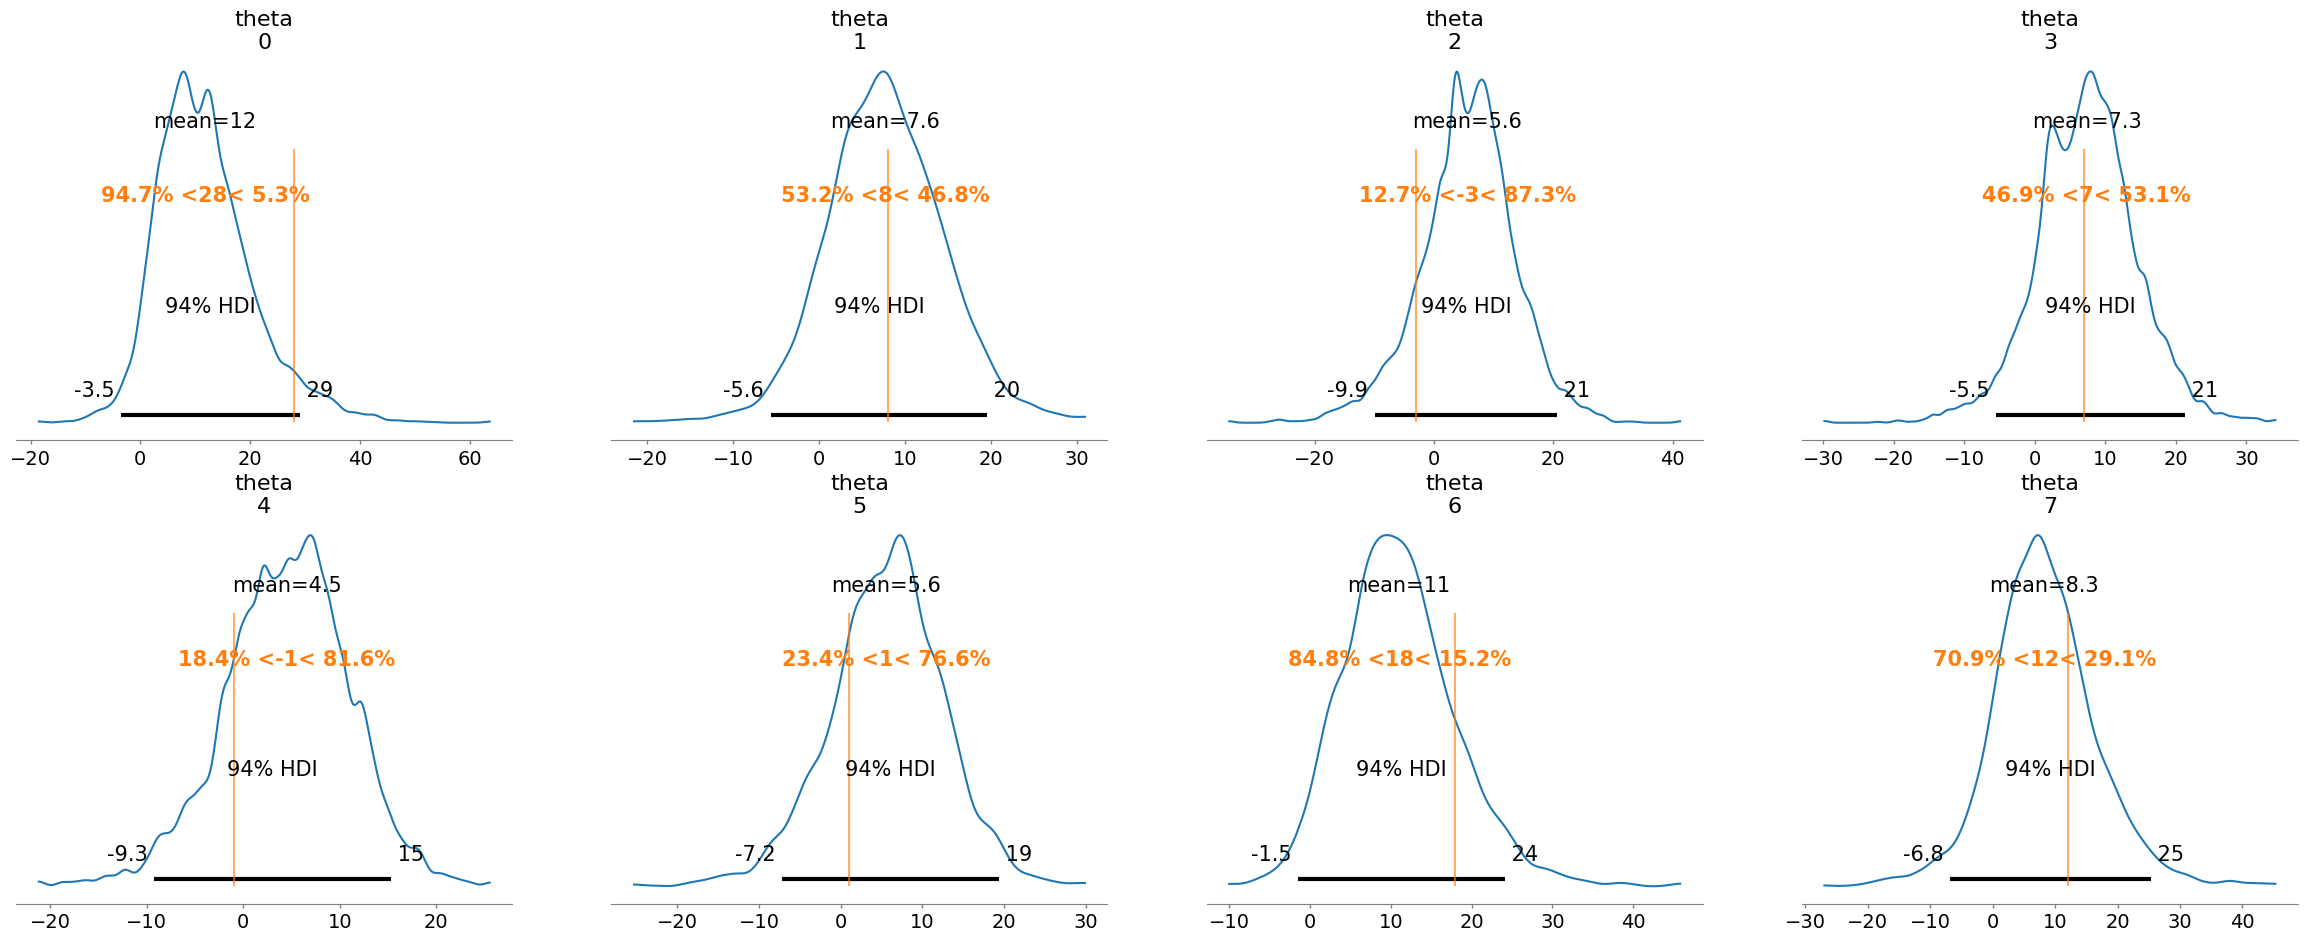

In [25]:
az.plot_posterior(
    trace_schools
    , var_names='theta'
    , ref_val=DatGroup['MeanGroup'].to_list()
)

Histogram of the maximum of $\theta$

Text(0.5, 0, 'Largest effect')

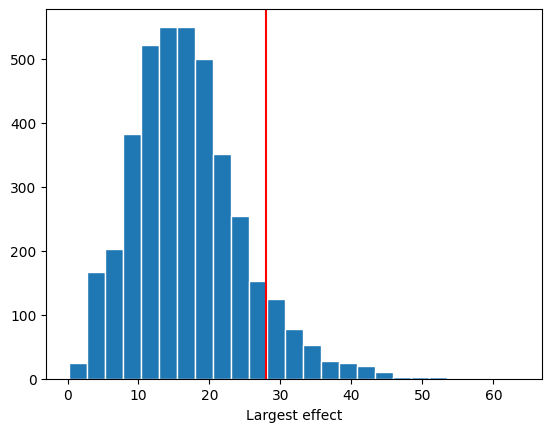

In [26]:
_, _, _ = plt.hist(trace_schools.posterior.theta.max(axis=2).values.ravel(), bins=25, edgecolor='w')
plt.axvline(DatGroup['MeanGroup'].max(), color='r')
plt.xlabel('Largest effect')

$P(\theta_1>\theta_3|\mathbf{Y})$

In [28]:
np.mean(trace_schools.posterior.theta[:,:,0].values.ravel() > trace_schools.posterior.theta[:,:,2].values.ravel())

0.7075

---

## Model Checking

Histograms the largest effect, $\max\{Y_j\}$.

Text(0.5, 0, 'Largest effect')

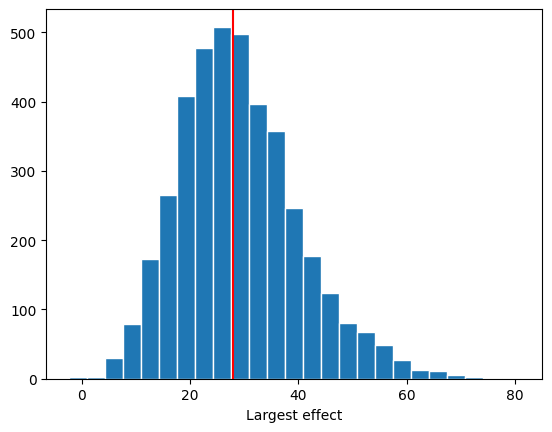

In [29]:
_, _, _ = plt.hist(trace_schools.posterior_predictive.obs.max(axis=2).values.ravel(), bins=25, edgecolor='w')
plt.axvline(DatGroup['MeanGroup'].max(), color='r')
plt.xlabel('Largest effect')

$P(\max\{Y_j\}\geq y_{(J)})$

In [30]:
np.mean(trace_schools.posterior_predictive.obs.max(axis=2).values.ravel() > DatGroup['MeanGroup'].max())

0.49625

---

## Evaluation of the models

### AIC

AIC for separate models

In [31]:
lpd = sum(norm.logpdf(DatGroup['MeanGroup'], loc=DatGroup['MeanGroup'], scale=DatGroup['SigmaJ']))
k   = 8

print(round(-2*lpd, 1))
print(round(-2*(lpd - k), 1))

54.6
70.6


AIC for pooled model

In [32]:
lpd = sum(norm.logpdf(DatGroup['MeanGroup'], loc=HatMuEmpirical, scale=DatGroup['SigmaJ']))
k   = 1

print(round(-2*lpd, 1))
print(round(-2*(lpd - k), 1))

59.3
61.3


### DIC

DIC for separate models

In [33]:
lpd = sum(norm.logpdf(DatGroup['MeanGroup'], loc=DatGroup['MeanGroup'], scale=DatGroup['SigmaJ']))

Loglike = []
pDIC = 0

for s in range(4000):
    ThetaSim = norm.rvs(size=J, loc=DatGroup['MeanGroup'], scale=DatGroup['SigmaJ'])
    Loglike.append(sum(norm.logpdf(DatGroup['MeanGroup'], loc=ThetaSim, scale=DatGroup['SigmaJ'])))

Loglike = np.array(Loglike)

pDIC = 2 * (lpd-np.mean(Loglike))
pDIC_alt = 2 * np.var(Loglike)

print(round(-2*lpd, 1))
print(round(pDIC, 1))
print(round(pDIC_alt, 1))
print(round(-2*(lpd - pDIC), 1))
print(round(-2*(lpd - pDIC_alt), 1))

54.6
8.0
7.8
70.7
70.2


DIC for pooled model

In [34]:
lpd = sum(norm.logpdf(DatGroup['MeanGroup'], loc=HatMuEmpirical, scale=DatGroup['SigmaJ']))

Loglike = []
pDIC = 0

for s in range(4000):
    ThetaSim = norm.rvs(size=J, loc=HatMuEmpirical, scale=np.sqrt(VarPooledEstimate))
    Loglike.append(sum(norm.logpdf(DatGroup['MeanGroup'], loc=ThetaSim, scale=DatGroup['SigmaJ'])))

Loglike = np.array(Loglike)

pDIC = 2 * (lpd-np.mean(Loglike))
pDIC_alt = 2 * np.var(Loglike)

print(round(-2*lpd, 1))
print(round(pDIC, 1))
print(round(pDIC_alt, 1))
print(round(-2*(lpd - pDIC), 1))
print(round(-2*(lpd - pDIC_alt), 1))

59.3
1.0
1.3
61.3
62.0


In [35]:
ThetaPosterior = trace_schools.posterior.stack(sample=["chain", "draw"]).theta.values.T

DIC for the hierarchical model

In [36]:
lpd = sum(norm.logpdf(DatGroup['MeanGroup'], loc=trace_schools.posterior.theta.mean(axis=(0,1)), scale=DatGroup['SigmaJ']))

Loglike = []

for s in range(4000):
    Loglike.append(sum(norm.logpdf(DatGroup['MeanGroup'], loc=ThetaPosterior[s], scale=DatGroup['SigmaJ'])))

Loglike = np.array(Loglike)

pDIC = 2 * (lpd-np.mean(Loglike))
pDIC_alt = 2 * np.var(Loglike)

print(round(-2*lpd, 1))
print(round(pDIC, 1))
print(round(pDIC_alt, 1))
print(round(-2*(lpd - pDIC), 1))
print(round(-2*(lpd - pDIC_alt), 1))

57.2
3.1
2.6
63.3
62.4


### WAIC

WAIC for the separate models

In [37]:
Lppd = 0
pWAIC1 = 0
pWAIC2 = 0

for i in range(len(DatGroup)):
    ThetaSim = norm.rvs(size=4000, loc=DatGroup['MeanGroup'][i], scale=DatGroup['SigmaJ'][i])
    Loglike = norm.logpdf(DatGroup['MeanGroup'][i], loc=ThetaSim, scale=DatGroup['SigmaJ'][i])
    Lppd += logsumexp(Loglike) - np.log(4000)
    pWAIC1 += Loglike.mean()
    pWAIC2 += np.var(Loglike)

pWAIC1 = 2 * (Lppd - pWAIC1)

print(round(-2*Lppd, 1))
print(round(pWAIC1, 1))
print(round(pWAIC2, 1))
print(round(-2*(Lppd - pWAIC1), 1))
print(round(-2*(Lppd - pWAIC2), 1))

60.2
2.5
4.1
65.2
68.4


WAIC for the pooled model

In [38]:
Lppd = 0
pWAIC1 = 0
pWAIC2 = 0

for i in range(len(DatGroup)):
    ThetaSim = norm.rvs(size=4000, loc=HatMuEmpirical, scale=np.sqrt(VarPooledEstimate))
    Loglike = norm.logpdf(DatGroup['MeanGroup'][i], loc=ThetaSim, scale=DatGroup['SigmaJ'][i])
    Lppd += logsumexp(Loglike) - np.log(4000)
    pWAIC1 += Loglike.mean()
    pWAIC2 += np.var(Loglike)

pWAIC1 = 2 * (Lppd - pWAIC1)

print(round(-2*Lppd, 1))
print(round(pWAIC1, 1))
print(round(pWAIC2, 1))
print(round(-2*(Lppd-pWAIC1), 1))
print(round(-2*(Lppd-pWAIC2), 1))

59.8
0.6
0.7
61.0
61.1


WAIC for the hierarchical model

In [39]:
TraceThetaAux = ThetaPosterior.T

Lppd = 0
pWAIC1 = 0
pWAIC2 = 0

for i in range(len(DatGroup)):
    Loglike = norm.logpdf(DatGroup['MeanGroup'][i], loc=TraceThetaAux[i], scale=DatGroup['SigmaJ'][i])
    Lppd += logsumexp(Loglike) - np.log(4000)
    pWAIC1 += Loglike.mean()
    pWAIC2 += np.var(Loglike)

pWAIC1 = 2 * (Lppd - pWAIC1)

print(round(-2*Lppd, 1))
print(round(pWAIC1, 1))
print(round(pWAIC2, 1))
print(round(-2*(Lppd - pWAIC1), 1))
print(round(-2*(Lppd - pWAIC2), 1))

59.2
1.1
1.4
61.4
62.1
